In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import GLM as gl

dtype = torch.float           
device = torch.device("cpu")

<ErrorbarContainer object of 3 artists>

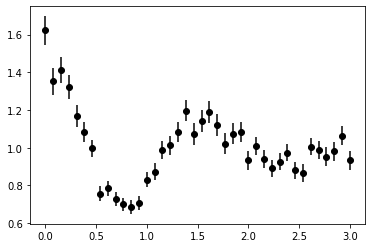

In [45]:
#f = lambda x,a,b,c: a*np.exp(0.3*x) + b*np.exp(-x**2) +c*x*np.exp(-0.6*x)
f = lambda x,a,b,c: a*np.exp(-b*x)*np.cos(c*x) + 1
#f = lambda x,a,b,c: a*x + b*x**2 + c*x**3

sig = 0.05
n_obs = 40


x_obs = np.linspace(0,3.,n_obs)
eps = np.random.normal(0.,sig,n_obs)

a = .5
b = .7
c = 3.9

y_obs = f(x_obs,a,b,c)*(1+eps)
dy_obs = np.abs(f(x_obs,a,b,c)*sig)

data = np.c_[x_obs,y_obs,dy_obs]

plt.errorbar(x_obs,y_obs,yerr=dy_obs,fmt='ko')

In [46]:
Activation = torch.nn.SiLU()
GL = gl.GL_from_NN(3,[8,5,3],Activation)

In [51]:
GL.fit(data,4000,5e-5)

Epoch = 1000 $\chi^2$ = 34.02
Epoch = 2000 $\chi^2$ = 33.88
Epoch = 3000 $\chi^2$ = 33.77
Epoch = 4000 $\chi^2$ = 33.68
End


In [52]:
prior_mean = np.array([0,0,0])
prior_cov = np.array([[0.04,0,0],[0,0.04,0],[0,0,0.04]])
GL.ini_Bayesian(prior_mean,prior_cov)

In [53]:
xx = np.linspace(0,3,200)
yy = GL.predict(xx)
yy_err = GL.best_fun_err(xx)

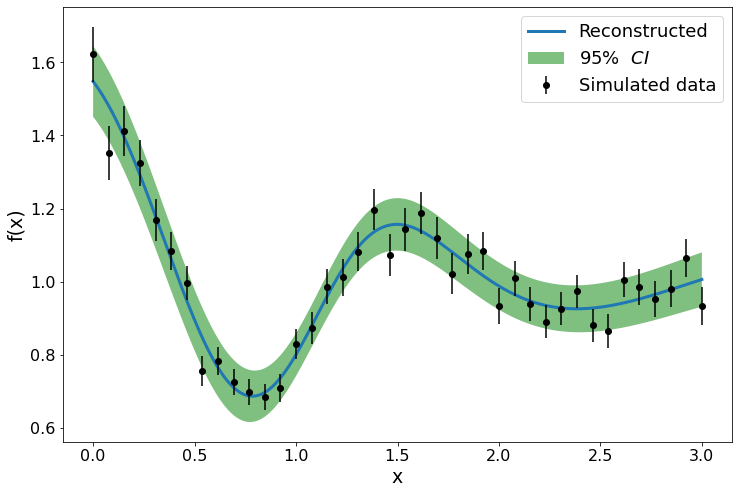

In [66]:
plt.rcParams['figure.figsize'] = (12,8)

plt.plot(xx,yy,lw=3,label="Reconstructed")
plt.errorbar(x_obs,y_obs,yerr=data[:,2],fmt='ko',label="Simulated data")
plt.fill_between(xx,yy - 1.9600 * yy_err,yy + 1.9600 * yy_err,alpha=.5, fc='g', ec='None',label="$95\% ~~ CI$")
plt.xlabel('x',fontsize=19)
plt.ylabel('f(x)',fontsize=19)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.savefig("sim.pdf")